In [20]:
from control.matlab import tf
import numpy as np
import matplotlib.pyplot as plt

"""
後で使う関数の定義
"""

def linestyle_generator():
    """グラフをプロットするときの線種を決めるジェネレータ"""
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

def plot_set(fig_ax, *args):
    """グラフを整える"""
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args) == 3:
        fig_ax.legend(loc=args[2])

def bodeplot_set(fig_ax, *args):
    """ボード線図を整える"""
    # ゲイン線図
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    # 位相線図
    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('omega [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')

    # 凡例
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

"""
垂直駆動アームのモデル
"""

g = 9.81
l = 0.2
M = 0.5
mu = 1.5e-2
J = 1.0e-2

P = tf([0, 1], [J, mu, M*g*l])

ref = 30 # 目標角度

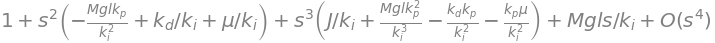

In [21]:
import sympy as sp

def test1():
    s = sp.Symbol('s')
    kp, kd, ki = sp.symbols('k_p k_d k_i')
    Mgl, mu, J = sp.symbols('Mgl mu J')
    sp.init_printing()

    G = (kp * s + ki) / (J * s ** 3 + (mu + kd)* s ** 2 + (Mgl + kp) * s + ki)
    return sp.series(1/G, s, 0, 4)

test1()

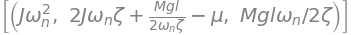

In [22]:
import sympy as sp

def test2():
    z, wn = sp.symbols('zeta omega_n')
    kd, kp, ki = sp.symbols('k_d k_p k_i')
    Mgl, mu, J = sp.symbols('Mgl mu J')
    sp.init_printing()

    f1 = Mgl / ki - 2 * z / wn
    f2 = (mu + kd) / ki - Mgl * kp / (ki ** 2) - 1/(wn ** 2)
    f3 = J/ki - kp * (mu + kd) / (ki ** 2) + Mgl * kp ** 2 / (ki ** 3)
    return sp.solve([f1, f2, f3], (kp, kd, ki))

test2()

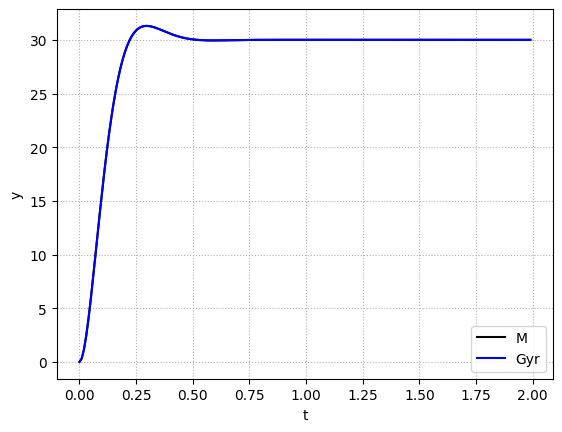

In [25]:
from control.matlab import tf, step

# 規範モデル
omega_n = 15
zeta = 0.707
Msys = tf([0, omega_n ** 2], [1, 2 * zeta * omega_n, omega_n ** 2])

# モデルマッチング
kp = omega_n ** 2 * J
ki = omega_n * M * g * l / (2 * zeta)
kd = 2 * zeta * omega_n * J + M * g * l / (2 * zeta * omega_n) - mu
Gyr = tf([kp, ki], [J, mu + kd, M * g * l + kp, ki])

yM, tM = step(Msys, np.arange(0, 2, 0.01))
y, t = step(Gyr, np.arange(0, 2, 0.01))

fig, ax = plt.subplots()
ax.plot(tM, yM * ref, label='M', color='k')
ax.plot(t, y * ref, label='Gyr', color='b')
plot_set(ax, 't', 'y', 'best')